In [1]:
# import libaries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import joblib
import random
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import regularizers
from sklearn import metrics
from scipy.io.arff import loadarff
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, precision_recall_curve

In [2]:
# 데이터 load
from google.colab import drive
drive.mount('/content/drive')
train = pd.read_csv('/content/drive/MyDrive/dmp/train.csv')
test = pd.read_csv('/content/drive/MyDrive/dmp/test.csv')
test=test.set_index('Timestamp')
train=train.set_index('Timestamp')

Mounted at /content/drive


In [3]:
scaler = MinMaxScaler()
scaler.fit(train)
scale_train = scaler.transform(train)
scale_test = scaler.transform(test)

In [4]:
train = pd.DataFrame(scale_train, columns = train.columns,index = train.index)
test = pd.DataFrame(scale_test, columns = test.columns,index = test.index)

In [5]:
# train, test, valid split

for i in range(len(train.columns)):
  if train.columns[i][-7:] == 'Request':
       train[train.columns[i][:-7]+'ratio'] = train[train.columns[i+1]]/train[train.columns[i]]



for i in range(len(test.columns)):
  if test.columns[i][-7:] == 'Request':
       test[test.columns[i][:-7]+'ratio'] = test[test.columns[i+1]]/test[test.columns[i]]


In [6]:
train = train.fillna(0)
test = test.fillna(0)

In [7]:
info_data = train.loc[:,[i for i in train.columns.values.tolist() if 'INFO' in i]]
login_1_data = train.loc[:,[i for i in train.columns.values.tolist() if 'LOGIN-01' in i]]
login_2_data = train.loc[:,[i for i in train.columns.values.tolist() if 'LOGIN-02' in i]]
login_3_data = train.loc[:,[i for i in train.columns.values.tolist() if 'LOGIN-03' in i]]
login_4_data = train.loc[:,[i for i in train.columns.values.tolist() if 'LOGIN-04' in i]]
login_5_data = train.loc[:,[i for i in train.columns.values.tolist() if 'LOGIN-05' in i]]
menu_1_data = train.loc[:,[i for i in train.columns.values.tolist() if 'MENU-01' in i]]
menu_2_data = train.loc[:,[i for i in train.columns.values.tolist() if 'MENU-02' in i]]
menu_3_data = train.loc[:,[i for i in train.columns.values.tolist() if 'MENU-03' in i]]
menu_4_data = train.loc[:,[i for i in train.columns.values.tolist() if 'MENU-04' in i]]

info_data_test = test.loc[:,[i for i in test.columns.values.tolist() if 'INFO' in i]]
login_1_data_test = test.loc[:,[i for i in test.columns.values.tolist() if 'LOGIN-01' in i]]
login_2_data_test = test.loc[:,[i for i in test.columns.values.tolist() if 'LOGIN-02' in i]]
login_3_data_test = test.loc[:,[i for i in test.columns.values.tolist() if 'LOGIN-03' in i]]
login_4_data_test = test.loc[:,[i for i in test.columns.values.tolist() if 'LOGIN-04' in i]]
login_5_data_test = test.loc[:,[i for i in test.columns.values.tolist() if 'LOGIN-05' in i]]
menu_1_data_test = test.loc[:,[i for i in test.columns.values.tolist() if 'MENU-01' in i]]
menu_2_data_test = test.loc[:,[i for i in test.columns.values.tolist() if 'MENU-02' in i]]
menu_3_data_test = test.loc[:,[i for i in test.columns.values.tolist() if 'MENU-03' in i]]
menu_4_data_test = test.loc[:,[i for i in test.columns.values.tolist() if 'MENU-04' in i]]

session = train.iloc[:,30:]
session_test = test.iloc[:,30:]

In [8]:
# 데이터 차원 변경 -> input 데이터 형식 맞춤 (3차원)
def rs(x):
  x = np.array(x).reshape(x.shape[0],1,x.shape[1])
  return x


data_list = [info_data, login_1_data,login_2_data,login_3_data,login_4_data,login_5_data,menu_1_data,menu_2_data,menu_3_data,menu_4_data,session]
data_list_test = [info_data_test, login_1_data_test,login_2_data_test,login_3_data_test,login_4_data_test,login_5_data_test,menu_1_data_test,menu_2_data_test,menu_3_data_test,menu_4_data_test,session_test]

info_data_x = rs(info_data)
info_data_test_x = rs(info_data_test)

login_1_data_x = rs(login_1_data)
login_1_data_test_x = rs(login_1_data_test)

login_2_data_x = rs(login_2_data)
login_2_data_test_x = rs(login_2_data_test)

login_3_data_x = rs(login_3_data)
login_3_data_test_x = rs(login_3_data_test)

login_4_data_x = rs(login_4_data)
login_4_data_test_x = rs(login_4_data_test)

login_5_data_x = rs(login_5_data)
login_5_data_test_x = rs(login_5_data_test)

menu_1_data_x = rs(menu_1_data)
menu_1_data_test_x = rs(menu_1_data_test)

menu_2_data_x = rs(menu_2_data)
menu_2_data_test_x = rs(menu_2_data_test)

menu_3_data_x = rs(menu_3_data)
menu_3_data_test_x = rs(menu_3_data_test)

menu_4_data_x = rs(menu_4_data)
menu_4_data_test_x = rs(menu_4_data_test)

session_x = rs(session)
session_test_x = rs(session_test)

reshape_list_train = [info_data_x, login_1_data_x,login_2_data_x,login_3_data_x,login_4_data_x,login_5_data_x,menu_1_data_x,menu_2_data_x,menu_3_data_x,menu_4_data_x,session_x]
reshape_list_test = [info_data_test_x, login_1_data_test_x,login_2_data_test_x,login_3_data_test_x,login_4_data_test_x,login_5_data_test_x,menu_1_data_test_x,menu_2_data_test_x,menu_3_data_test_x,menu_4_data_test_x,session_test_x]

#train = np.array(train).reshape(train.shape[0],1,train.shape[1])
#test = np.array(test).reshape(test.shape[0],1,test.shape[1])

In [9]:
info_data_x.shape

(105120, 1, 4)

In [10]:
sum(np.isnan(login_1_data_x)==False)

array([[105120, 105120, 105120, 105120]])

In [11]:
login_1_data_x[np.isnan(login_1_data_x)==True]

array([], dtype=float64)

In [12]:
# 신경망 구축

# autoencoder 신경망 구축 (신경망을 LSTM layer로 구축) #1-> dropout 0.2 0.2 #2 dropoutx
def autoencoder_model(X):
  inputs = Input(shape=(X.shape[1], X.shape[2]))
  L1 = LSTM(140, activation='relu', return_sequences=True, kernel_regularizer=regularizers.l2(0.00))(inputs)
  L3 = LSTM(70, activation='relu', return_sequences=False)(L1)
  L4 = RepeatVector(X.shape[1])(L3)
  L5 = LSTM(70, activation='relu', return_sequences=True)(L4)
  L6 = LSTM(140, activation='relu', return_sequences=True)(L5)
  output = TimeDistributed(Dense(X.shape[2]))(L6)
  model = Model(inputs=inputs, outputs=output)

  return model

In [13]:
def modeling(train_x):

  model = autoencoder_model(train_x)
  model.compile(optimizer='adam', loss='mae')
  model.summary()

  nb_epochs = 20
  batch_size = 32
  history = model.fit(train_x, train_x, epochs=nb_epochs, batch_size=batch_size)
  return model,history

In [14]:
# 학습 결과 시각화
def viz(hist):
  fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
  ax.plot(hist.history['loss'], 'b', label='Train', linewidth=2)
  ax.set_title('Model loss', fontsize=16)
  ax.set_ylabel('Loss (mae)')
  ax.set_xlabel('Epoch')
  ax.legend(loc='upper right')
  plt.show()

In [15]:
# loss
def loss_fun(model,history,train_x,x):

  x_pred_3d = model.predict(train_x)
  x_pred = x_pred_3d.reshape(x_pred_3d.shape[0], x_pred_3d.shape[2])
  x_pred = pd.DataFrame(x_pred,columns = x.columns)
  x_pred.index = x.index

  scored = pd.DataFrame(index = x.index)
  xtrain = train_x.reshape(train_x.shape[0], train_x.shape[2])
  scored['Loss_mae'] =np.mean(np.abs(x_pred-xtrain),axis=1)
  sns.distplot(scored['Loss_mae'],kde=True)

  return model, scored

In [16]:
# test
def testing(model, score, test_x, t,feature):

  threshold = np.percentile(score,100)
  test_predictions_3d = model.predict(test_x)
  test_predictions = test_predictions_3d.reshape(test_predictions_3d.shape[0], test_predictions_3d.shape[2])
  test_predictions = pd.DataFrame(test_predictions,columns = t.columns)
  test_predictions.index = t.index

  scored2 = pd.DataFrame(index = t.index)
  x_test_ = test_x.reshape(test_x.shape[0], test_x.shape[2])
  scored2[feature+'mae'] = np.mean(np.abs(test_predictions - x_test_), axis=1)

  scored2[feature+'threshold'] = threshold
  scored2[feature+'Anomaly'] = scored2[feature+'mae'] > scored2[feature+'threshold']
    
  

  return scored2

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 4)]            0         
                                                                 
 lstm (LSTM)                 (None, 1, 140)            81200     
                                                                 
 lstm_1 (LSTM)               (None, 70)                59080     
                                                                 
 repeat_vector (RepeatVector  (None, 1, 70)            0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 1, 70)             39480     
                                                                 
 lstm_3 (LSTM)               (None, 1, 140)            118160    
                                                             

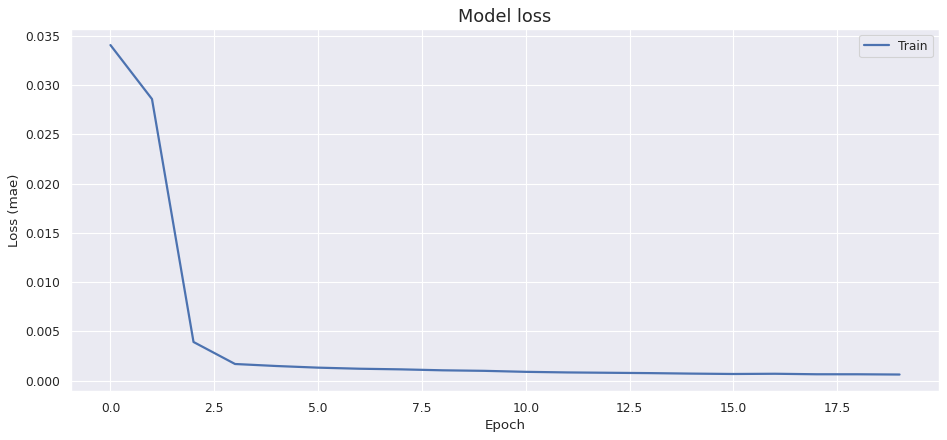

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1, 4)]            0         
                                                                 
 lstm_4 (LSTM)               (None, 1, 140)            81200     
                                                                 
 lstm_5 (LSTM)               (None, 70)                59080     
                                                                 
 repeat_vector_1 (RepeatVect  (None, 1, 70)            0         
 or)                                                             
                                                                 
 lstm_6 (LSTM)               (None, 1, 70)             39480     
                                                                 
 lstm_7 (LSTM)               (None, 1, 140)            118160    
                                                           

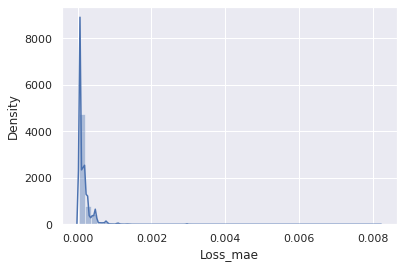

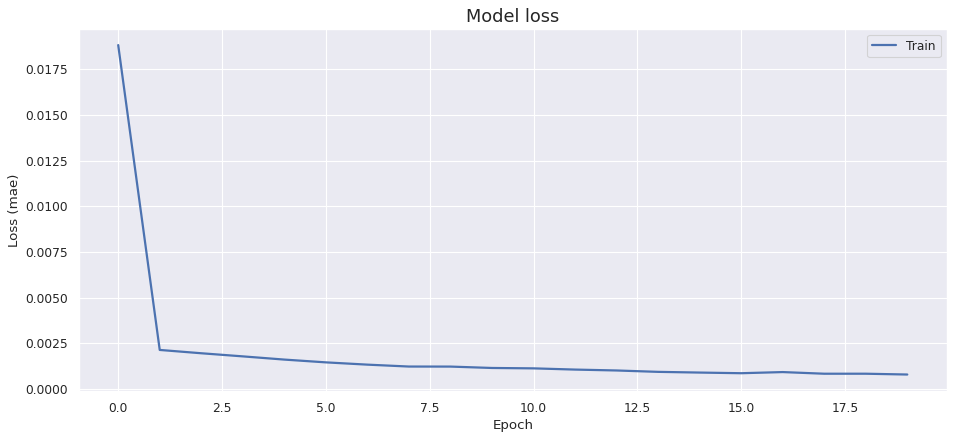

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1, 4)]            0         
                                                                 
 lstm_8 (LSTM)               (None, 1, 140)            81200     
                                                                 
 lstm_9 (LSTM)               (None, 70)                59080     
                                                                 
 repeat_vector_2 (RepeatVect  (None, 1, 70)            0         
 or)                                                             
                                                                 
 lstm_10 (LSTM)              (None, 1, 70)             39480     
                                                                 
 lstm_11 (LSTM)              (None, 1, 140)            118160    
                                                           

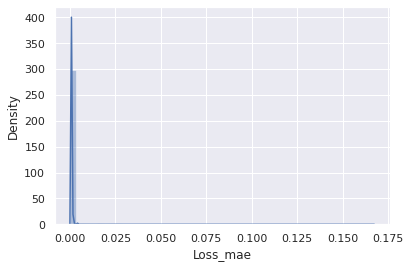

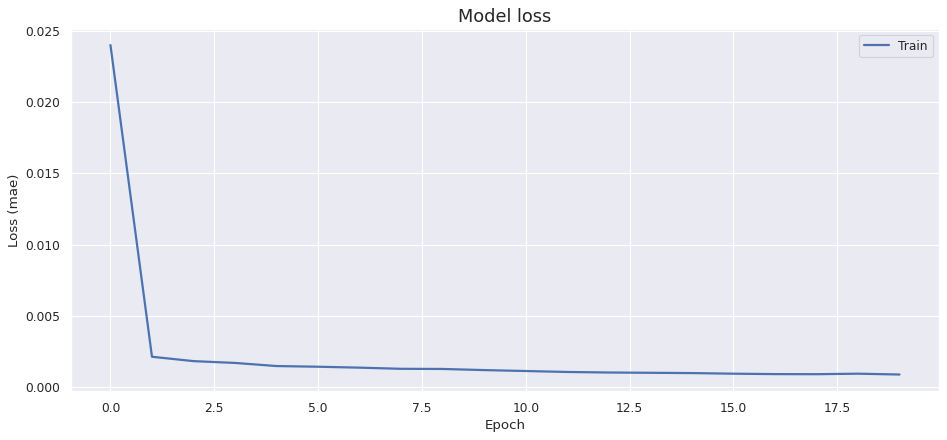

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1, 4)]            0         
                                                                 
 lstm_12 (LSTM)              (None, 1, 140)            81200     
                                                                 
 lstm_13 (LSTM)              (None, 70)                59080     
                                                                 
 repeat_vector_3 (RepeatVect  (None, 1, 70)            0         
 or)                                                             
                                                                 
 lstm_14 (LSTM)              (None, 1, 70)             39480     
                                                                 
 lstm_15 (LSTM)              (None, 1, 140)            118160    
                                                           

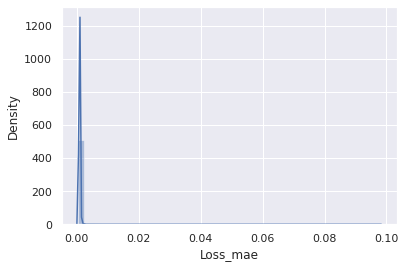

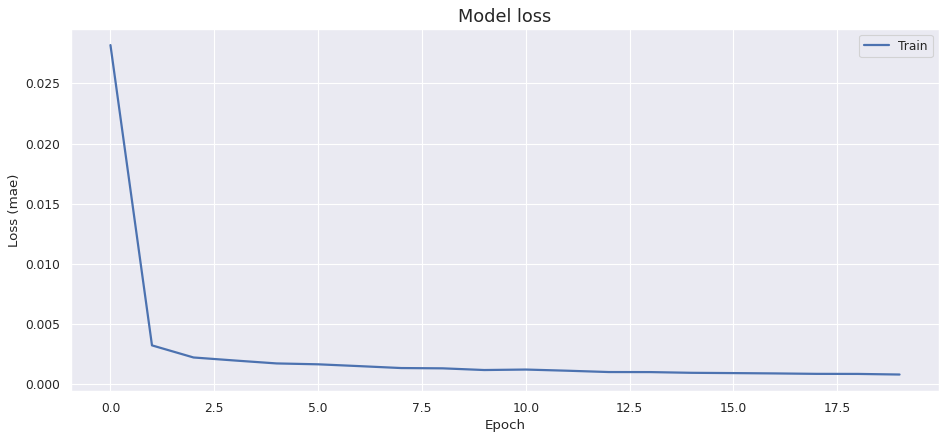

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1, 4)]            0         
                                                                 
 lstm_16 (LSTM)              (None, 1, 140)            81200     
                                                                 
 lstm_17 (LSTM)              (None, 70)                59080     
                                                                 
 repeat_vector_4 (RepeatVect  (None, 1, 70)            0         
 or)                                                             
                                                                 
 lstm_18 (LSTM)              (None, 1, 70)             39480     
                                                                 
 lstm_19 (LSTM)              (None, 1, 140)            118160    
                                                           

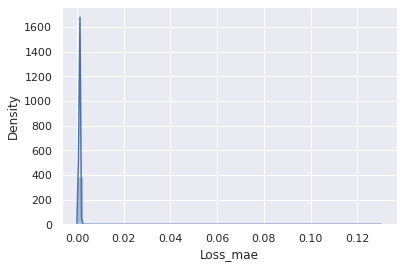

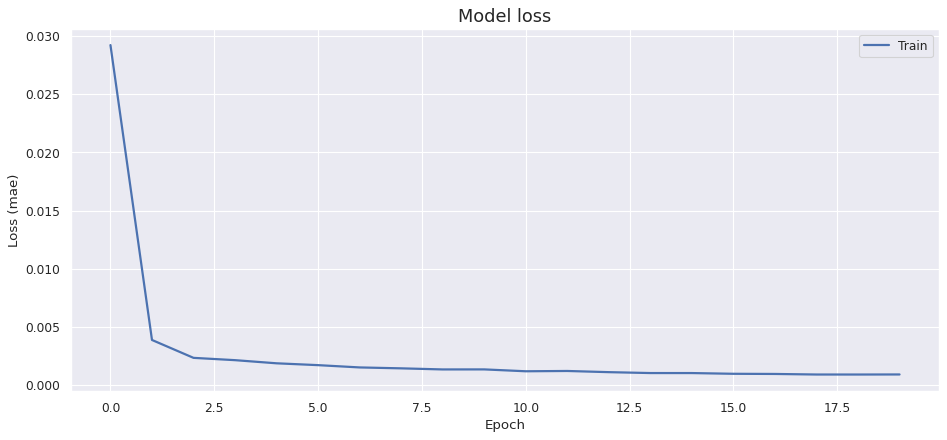

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1, 4)]            0         
                                                                 
 lstm_20 (LSTM)              (None, 1, 140)            81200     
                                                                 
 lstm_21 (LSTM)              (None, 70)                59080     
                                                                 
 repeat_vector_5 (RepeatVect  (None, 1, 70)            0         
 or)                                                             
                                                                 
 lstm_22 (LSTM)              (None, 1, 70)             39480     
                                                                 
 lstm_23 (LSTM)              (None, 1, 140)            118160    
                                                           

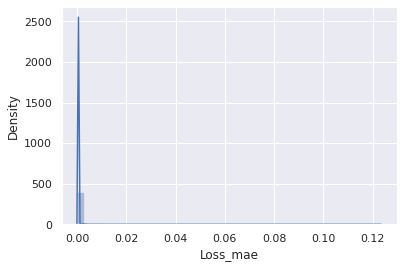

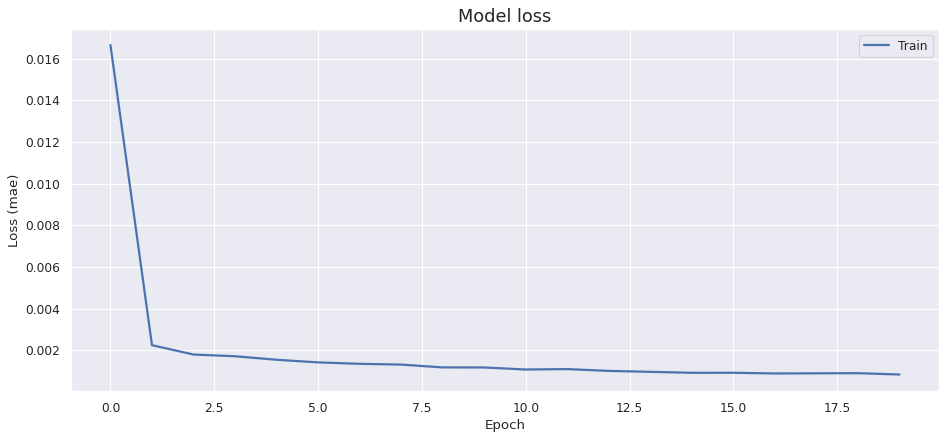

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 1, 4)]            0         
                                                                 
 lstm_24 (LSTM)              (None, 1, 140)            81200     
                                                                 
 lstm_25 (LSTM)              (None, 70)                59080     
                                                                 
 repeat_vector_6 (RepeatVect  (None, 1, 70)            0         
 or)                                                             
                                                                 
 lstm_26 (LSTM)              (None, 1, 70)             39480     
                                                                 
 lstm_27 (LSTM)              (None, 1, 140)            118160    
                                                           

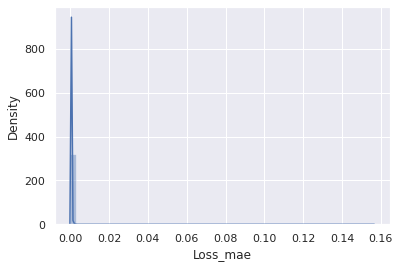

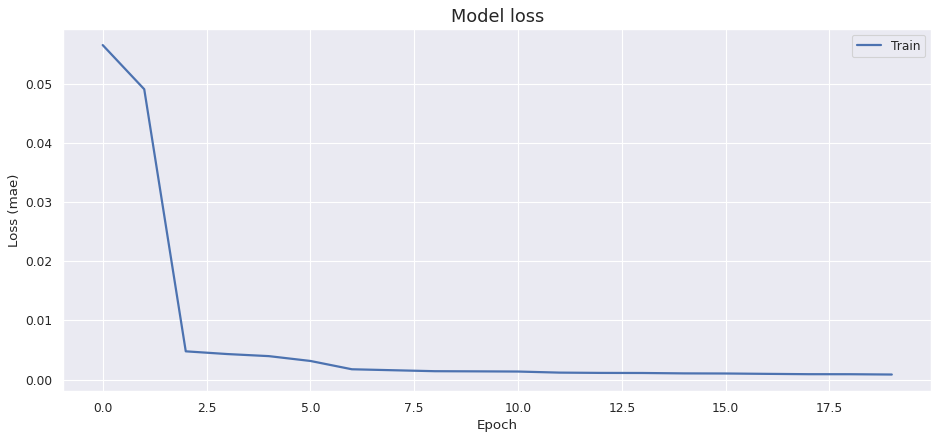

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 1, 4)]            0         
                                                                 
 lstm_28 (LSTM)              (None, 1, 140)            81200     
                                                                 
 lstm_29 (LSTM)              (None, 70)                59080     
                                                                 
 repeat_vector_7 (RepeatVect  (None, 1, 70)            0         
 or)                                                             
                                                                 
 lstm_30 (LSTM)              (None, 1, 70)             39480     
                                                                 
 lstm_31 (LSTM)              (None, 1, 140)            118160    
                                                           

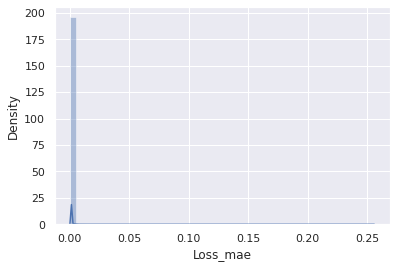

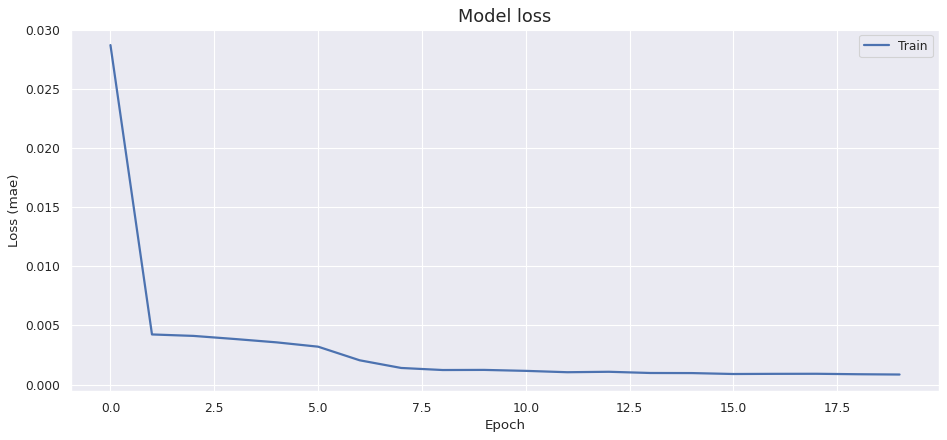

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 1, 4)]            0         
                                                                 
 lstm_32 (LSTM)              (None, 1, 140)            81200     
                                                                 
 lstm_33 (LSTM)              (None, 70)                59080     
                                                                 
 repeat_vector_8 (RepeatVect  (None, 1, 70)            0         
 or)                                                             
                                                                 
 lstm_34 (LSTM)              (None, 1, 70)             39480     
                                                                 
 lstm_35 (LSTM)              (None, 1, 140)            118160    
                                                           

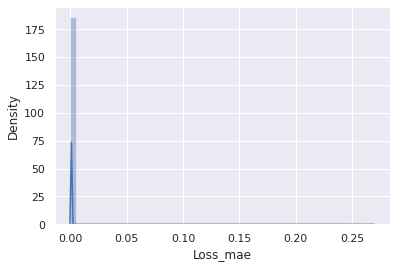

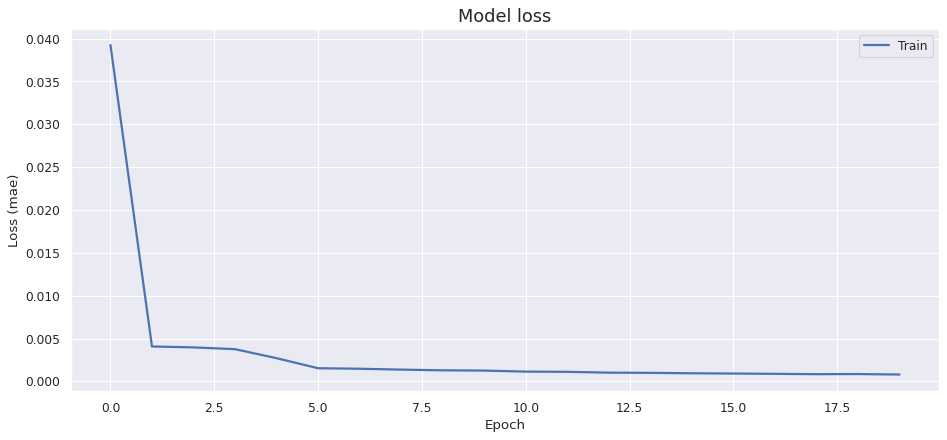

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 1, 4)]            0         
                                                                 
 lstm_36 (LSTM)              (None, 1, 140)            81200     
                                                                 
 lstm_37 (LSTM)              (None, 70)                59080     
                                                                 
 repeat_vector_9 (RepeatVect  (None, 1, 70)            0         
 or)                                                             
                                                                 
 lstm_38 (LSTM)              (None, 1, 70)             39480     
                                                                 
 lstm_39 (LSTM)              (None, 1, 140)            118160    
                                                           

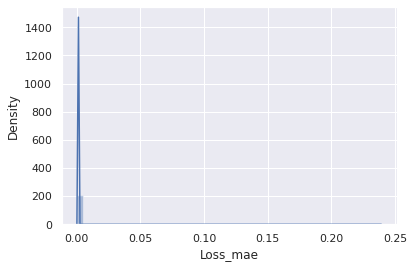

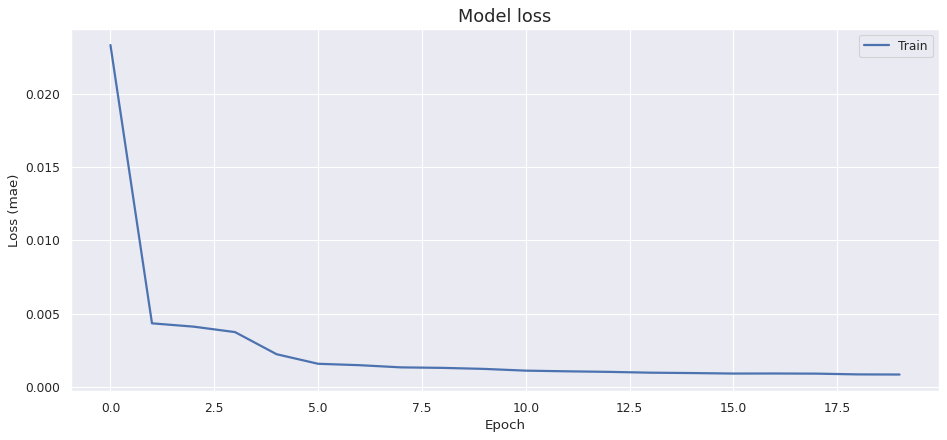

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 1, 13)]           0         
                                                                 
 lstm_40 (LSTM)              (None, 1, 140)            86240     
                                                                 
 lstm_41 (LSTM)              (None, 70)                59080     
                                                                 
 repeat_vector_10 (RepeatVec  (None, 1, 70)            0         
 tor)                                                            
                                                                 
 lstm_42 (LSTM)              (None, 1, 70)             39480     
                                                                 
 lstm_43 (LSTM)              (None, 1, 140)            118160    
                                                          

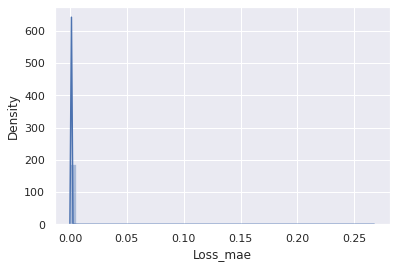

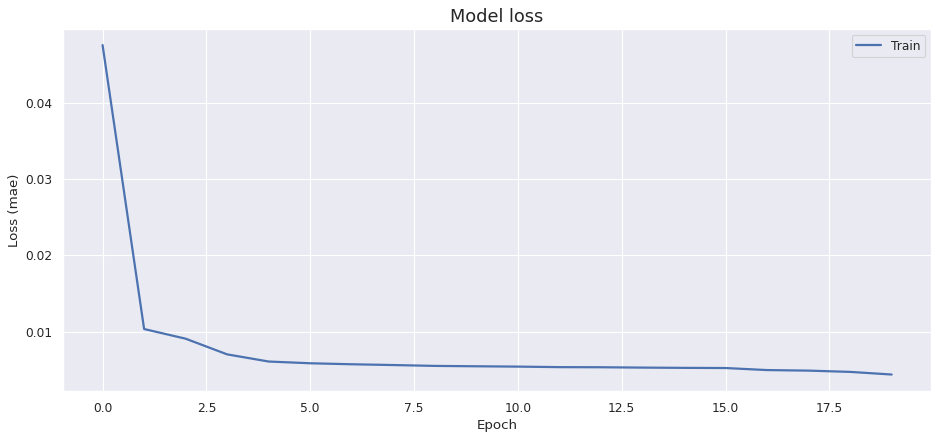

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


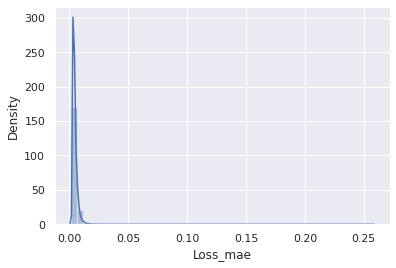

In [17]:
feature_list = ['info', 'login_1','login_2','login_3','login_4','login_5','menu_1','menu_2','menu_3','menu_4','session']
total_result = pd.DataFrame(index=test.index)


for i in range(len(feature_list)):

  m, h = modeling(reshape_list_train[i]) #reshape_list_train[i] -> reshape data, m = model, h = history
  viz(h) # viz history
  m,s = loss_fun(m,h,reshape_list_train[i],data_list[i]) # lossfunction ->model,history,train_x, index용 데이터 -> model, scored
  result = testing(m,s,reshape_list_test[i],data_list_test[i],feature_list[i]) #testing -> test_x: reshape_data  , t-> index용 데이터 feature -> 결과 column용 데이터
  total_result = pd.concat([total_result, result],axis=1)

In [18]:
total_result.to_csv('/content/drive/MyDrive/dmp/result2.csv',index = True)

In [19]:
total_result.value_counts()

infomae   infothreshold  infoAnomaly  login_1mae  login_1threshold  login_1Anomaly  login_2mae  login_2threshold  login_2Anomaly  login_3mae  login_3threshold  login_3Anomaly  login_4mae  login_4threshold  login_4Anomaly  login_5mae  login_5threshold  login_5Anomaly  menu_1mae  menu_1threshold  menu_1Anomaly  menu_2mae  menu_2threshold  menu_2Anomaly  menu_3mae  menu_3threshold  menu_3Anomaly  menu_4mae  menu_4threshold  menu_4Anomaly  sessionmae  sessionthreshold  sessionAnomaly
0.000045  0.008161       False        0.000299    0.167214          False           0.000845    0.098111          False           0.001059    0.130125          False           0.000628    0.123234          False           0.000616    0.156402          False           0.000714   0.255671         False          0.000320   0.269214         False          0.001221   0.239007         False          0.000996   0.267195         False          0.004621    0.257986          False             1
0.000404  0.008161       

In [20]:
l = pd.DataFrame()

for i in total_result.columns:
  if 'Anomaly' in i:
    l = pd.concat([l,total_result[i]],axis=1)

l0 = l.sum(axis=1)

In [21]:
l0

2018-01-01 00:05:00    0
2018-01-01 00:10:00    0
2018-01-01 00:15:00    0
2018-01-01 00:20:00    0
2018-01-01 00:25:00    0
                      ..
2018-12-31 23:35:00    1
2018-12-31 23:40:00    1
2018-12-31 23:45:00    1
2018-12-31 23:50:00    1
2018-12-31 23:55:00    1
Length: 105119, dtype: int64

In [22]:
l1=l0[l0==0].index
media_lstm_answer = pd.DataFrame(index=total_result.index)
media_lstm_answer.loc[l1,'Prediction'] = 0

In [23]:
media_lstm_answer.loc['2018-01-01 00:00:00','Prediction']=0

In [24]:
media_lstm_answer = media_lstm_answer.reset_index(drop=True).shift(1)

In [25]:
media_lstm_answer=media_lstm_answer.fillna(1)
media_lstm_answer

,Prediction
0,1.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
105115,1.0
105116,1.0
105117,1.0
105118,1.0


In [26]:
media_lstm_answer.to_csv('/content/drive/MyDrive/dmp/media_lstm_answer_mmscaling2.csv',index=False)

In [27]:
media_lstm_answer.value_counts()

Prediction
0.0           105015
1.0              105
dtype: int64